## DBSCAN Implementation

In [134]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [135]:
# loading the dataset
df = pd.read_csv('lipinski_balanced_smote.csv')

In [136]:
# define features
feature_cols = ['MolWt', 'LogP', 'NumHDonors', 'NumHAcceptors', 'TPSA', 'NumRotatableBonds']
X = df[feature_cols].values
lipinski_labels = df['Lipinski_Pass'].values

In [137]:
df.shape

(20392, 7)

In [138]:
print("The data below is standardized in the EDA file:\n")
df.head()

The data below is standardized in the EDA file:



,MolWt,LogP,NumHDonors,NumHAcceptors,TPSA,NumRotatableBonds,Lipinski_Pass
0,1.629652,-1.059655,1.491575,1.855776,2.038806,2.477233,0.0
1,1.699947,-0.334259,1.491575,1.249972,1.576542,2.788072,0.0
2,1.361246,-0.468688,1.491575,1.249972,1.576542,2.788072,0.0
3,1.640575,-0.091589,1.491575,1.249972,1.576542,2.477233,0.0
4,0.308036,0.690573,-0.002482,0.038366,0.273672,0.612200,1.0


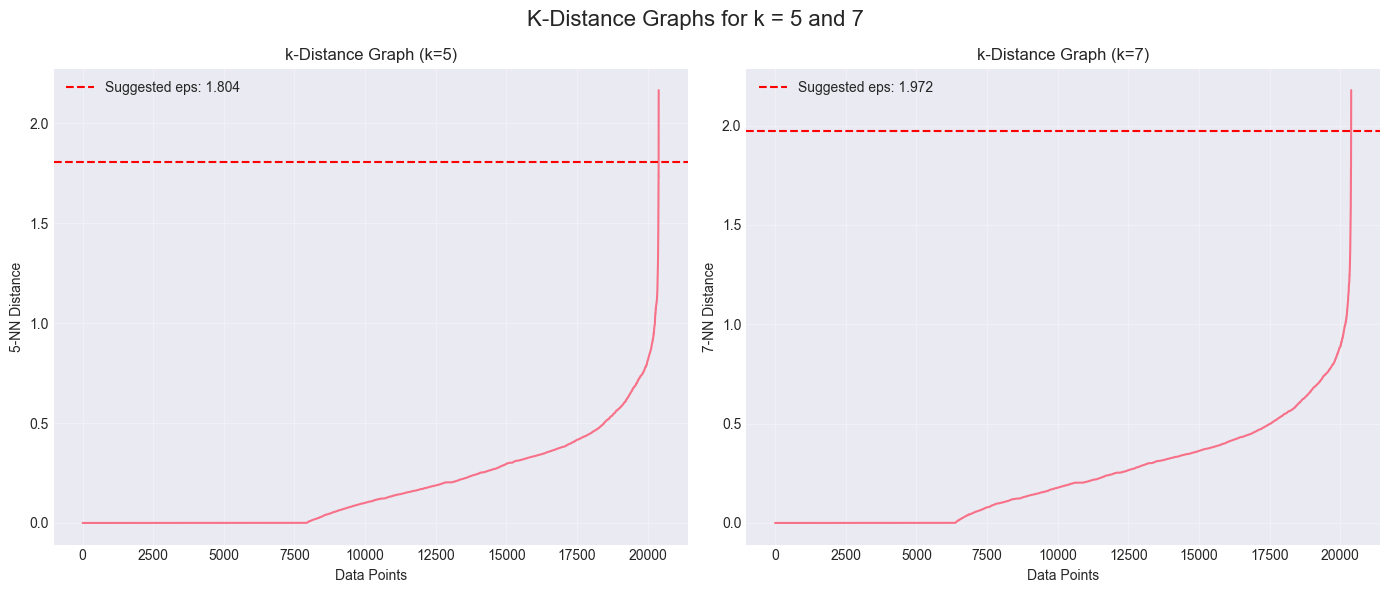

In [139]:
# plotting k distance graph for specified k values to find optimal eps
def find_optimal_eps(X, k_values=[5, 7]):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes = axes.ravel()
    
    for idx, k in enumerate(k_values):
        # computing k-nearest neighbors
        nbrs = NearestNeighbors(n_neighbors=k)
        nbrs.fit(X)
        distances, indices = nbrs.kneighbors(X)
        
        # sorting k-th nearest neighbor distance
        k_distances = np.sort(distances[:, k-1])
        
        # plot
        ax = axes[idx]
        ax.plot(k_distances)
        ax.set_xlabel('Data Points')
        ax.set_ylabel(f'{k}-NN Distance')
        ax.set_title(f'k-Distance Graph (k={k})')
        ax.grid(True, alpha=0.3)
        
        # finding elbow point using gradient
        gradients = np.gradient(k_distances)
        elbow_idx = np.argmax(gradients)
        suggested_eps = k_distances[elbow_idx]
        ax.axhline(y=suggested_eps, color='red', linestyle='--', 
                   label=f'Suggested eps: {suggested_eps:.3f}')
        ax.legend()
    
    plt.suptitle('K-Distance Graphs for k = 5 and 7', fontsize=16)
    plt.tight_layout()
    plt.show()

suggested_eps = find_optimal_eps(X, k_values=[5, 7])

In [140]:
# grid search for optimal dbscan parameters

def dbscan_grid_search(X, eps_range, min_samples_range):
    results = []    
    for eps in eps_range:
        for min_samples in min_samples_range:
            # Fit DBSCAN
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(X)
            
            # Calculate metrics
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)
            noise_ratio = n_noise / len(labels)
            
            # Calculate silhouette score (only if we have clusters)
            if n_clusters > 1 and n_clusters < len(X) - 1:
                # Exclude noise points for silhouette score
                mask = labels != -1
                if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
                    silhouette = silhouette_score(X[mask], labels[mask])
                else:
                    silhouette = -1
            else:
                silhouette = -1
            
            results.append({
                'eps': eps,
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'noise_ratio': noise_ratio,
                'silhouette_score': silhouette
            })
    
    return pd.DataFrame(results)

In [141]:
# define fixed eps range
eps_min, eps_max = 0.37, 0.8
eps_range = np.linspace(eps_min, eps_max, 15)
min_samples_range = [20, 30, 40, 50]

print(f"Testing eps range: {eps_min:.3f} to {eps_max:.3f}")
print(f"Testing min_samples: {min_samples_range}")

# perform grid search
results_df = dbscan_grid_search(X, eps_range, min_samples_range)

Testing eps range: 0.370 to 0.800
Testing min_samples: [20, 30, 40, 50]


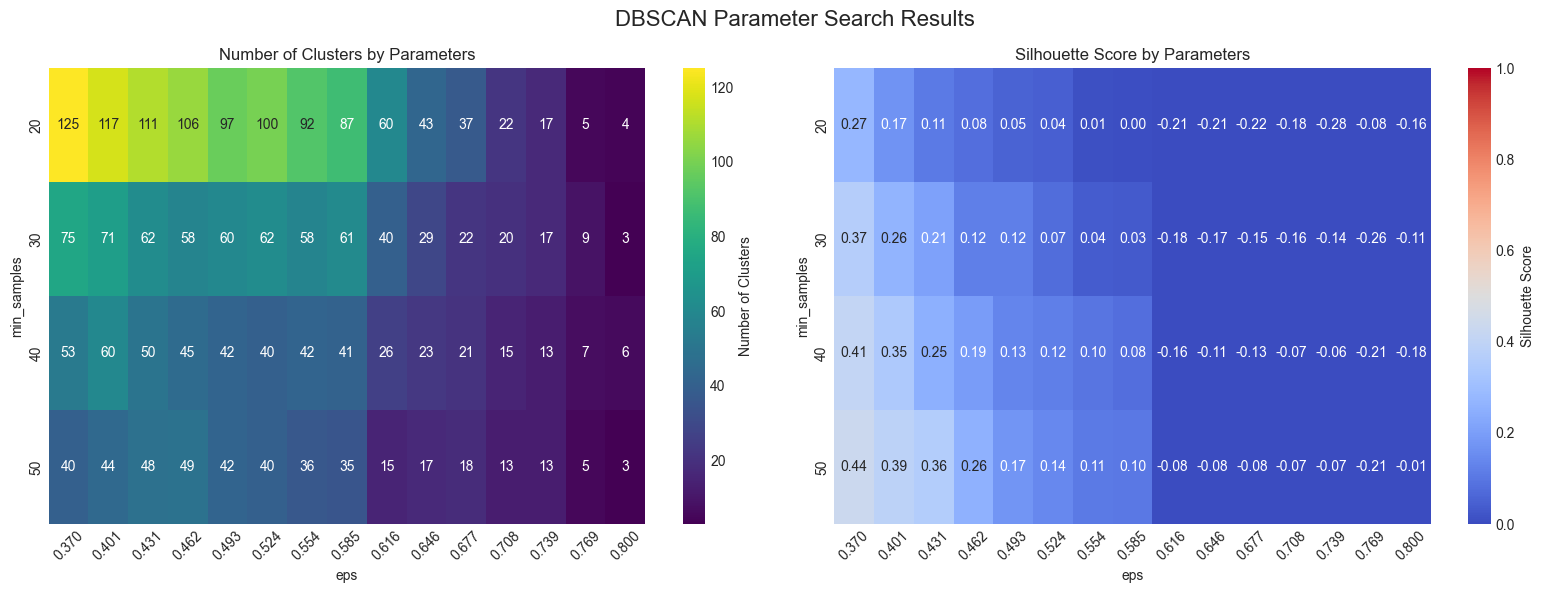

In [142]:
# dbscan parameter search results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# heatmap of number of clusters
pivot_clusters = results_df.pivot(index='min_samples', columns='eps', values='n_clusters')
sns.heatmap(pivot_clusters, annot=True, fmt='d', cmap='viridis', ax=axes[0], cbar_kws={'label': 'Number of Clusters'})
axes[0].set_title('Number of Clusters by Parameters')
axes[0].set_xlabel('eps')
axes[0].set_xticklabels([f'{x:.3f}' for x in eps_range], rotation=45)

# heatmap of silhouette scores
pivot_silhouette = results_df.pivot(index='min_samples', columns='eps', values='silhouette_score')
# Replace -1 with NaN for better visualization
pivot_silhouette_vis = pivot_silhouette.replace(-1, np.nan)
sns.heatmap(pivot_silhouette_vis, annot=True, fmt='.2f', cmap='coolwarm', ax=axes[1], 
            cbar_kws={'label': 'Silhouette Score'}, vmin=0, vmax=1)
axes[1].set_title('Silhouette Score by Parameters')
axes[1].set_xlabel('eps')
axes[1].set_xticklabels([f'{x:.3f}' for x in eps_range], rotation=45)

plt.suptitle('DBSCAN Parameter Search Results', fontsize=16)
plt.tight_layout()
plt.show()

In [143]:
# best parameters
valid_silhouette = results_df[results_df['silhouette_score'] > -1]
if len(valid_silhouette) > 0:
    best_silhouette = valid_silhouette.loc[valid_silhouette['silhouette_score'].idxmax()]
    print(f"Best parameters by silhouette score:")
    print(f"\neps: {best_silhouette['eps']:.3f}, min_samples: {best_silhouette['min_samples']}")
    print(f"Silhouette score: {best_silhouette['silhouette_score']:.3f}")
    print(f"Number of clusters: {best_silhouette['n_clusters']}, Noise ratio: {best_silhouette['noise_ratio']:.3f}")

Best parameters by silhouette score:

eps: 0.370, min_samples: 50.0
Silhouette score: 0.436
Number of clusters: 40.0, Noise ratio: 0.726


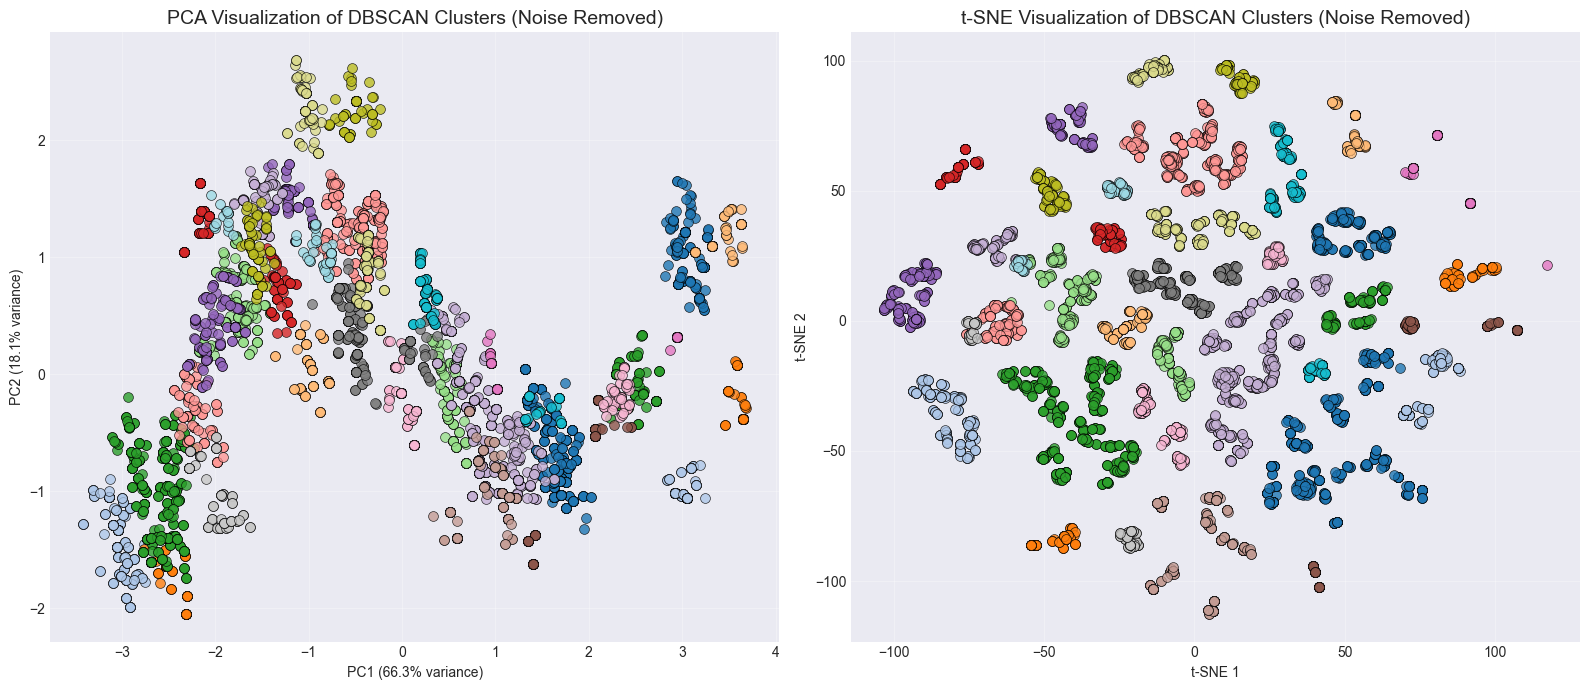

In [153]:
# Apply DBSCAN with best parameters
if len(valid_silhouette) > 0:
    best_eps = best_silhouette['eps']
    best_min_samples = int(best_silhouette['min_samples'])
    
    # Fit DBSCAN with best parameters
    dbscan_best = DBSCAN(eps=best_eps, min_samples=best_min_samples)
    labels = dbscan_best.fit_predict(X)
    
    # Filter out noise points
    mask_not_noise = labels != -1
    X_filtered = X[mask_not_noise]
    labels_filtered = labels[mask_not_noise]
    
    # Get unique labels (excluding noise)
    unique_labels = set(labels_filtered)
    n_clusters = len(unique_labels)
    
    # Create color palette
    colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))
    
    # Apply PCA on filtered data
    pca = PCA(n_components=2, random_state=42)
    X_pca = pca.fit_transform(X_filtered)
    
    # Apply t-SNE on filtered data
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
    X_tsne = tsne.fit_transform(X_filtered)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(16, 7))
    
    # PCA visualization
    ax1 = axes[0]
    for i, label in enumerate(sorted(unique_labels)):
        mask = labels_filtered == label
        ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                   c=[colors[i]], s=50, alpha=0.8, 
                   edgecolors='black', linewidth=0.5, label=f'Cluster {label}')
    
    ax1.set_title(f'PCA Visualization of DBSCAN Clusters (Noise Removed)', 
                  fontsize=14)
    ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    ax1.grid(True, alpha=0.3)
    
    # t-SNE visualization
    ax2 = axes[1]
    for i, label in enumerate(sorted(unique_labels)):
        mask = labels_filtered == label
        ax2.scatter(X_tsne[mask, 0], X_tsne[mask, 1], 
                   c=[colors[i]], s=50, alpha=0.8, 
                   edgecolors='black', linewidth=0.5, label=f'Cluster {label}')
    
    ax2.set_title(f't-SNE Visualization of DBSCAN Clusters (Noise Removed)', 
                  fontsize=14)
    ax2.set_xlabel('t-SNE 1')
    ax2.set_ylabel('t-SNE 2')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()